# Import & Parameter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import time
from enum import Enum
import math
import torch.ao.quantization as tq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.quantized as nnq

# 參數
num_classes = 100
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

MODEL_PATH = "./weights/vit.pt"
QUANT_MODEL_PATH = "./weights/quant_vit.pt"

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Is cuda avaliable: " , torch.cuda.is_available())

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Is cuda avaliable:  True


In [3]:
def get_cifar100_loaders(batch_size, root="data/cifar100", split_ratio=0.1, image_size=72):
    # train 資料增強
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(2),
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),  # CIFAR-100 平均值
                             (0.2675, 0.2565, 0.2761)), # CIFAR-100 標準差
    ])
    # val/test 無增強
    eval_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                             (0.2675, 0.2565, 0.2761)),
    ])
    trainset = datasets.CIFAR100(root=root, train=True,  download=True, transform=transform)
    testset  = datasets.CIFAR100(root=root, train=False, download=True, transform=eval_transform)
    # 切分出小比例當 val
    val_len   = int(split_ratio * len(trainset))
    train_len = len(trainset) - val_len
    trainset, valset = random_split(trainset, [train_len, val_len])
    return (
        DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=2),
        DataLoader(valset,   batch_size=batch_size, shuffle=False, num_workers=2),
        DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=2),
    )

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(units[0], units[1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [5]:
class Patches(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, images):
        # images: [B, C, H, W]
        B, C, H, W = images.shape
        ph, pw = self.patch_size, self.patch_size
        assert H % ph == 0 and W % pw == 0
        # 轉成 [B, num_patches, patch_dim]
        patches = images.unfold(2, ph, ph).unfold(3, pw, pw)  # [B, C, nph, npw, ph, pw]
        patches = patches.permute(0, 2, 3, 1, 4, 5)  # [B, nph, npw, C, ph, pw]
        patches = patches.reshape(B, -1, C * ph * pw)  # [B, num_patches, patch_dim]
        return patches

class PatchEncoder(nn.Module):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.proj = nn.Linear(patch_size * patch_size * 3, projection_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, projection_dim))
        self.adder   = nnq.FloatFunctional()
        self.quant   = tq.QuantStub()
        self.dequant = tq.DeQuantStub()
        
    def forward(self, x):
        # 1) 如果是量化張量，反量化到 float
        if x.is_quantized:
            x = self.dequant(x)
        # 2) 在 float 做投影 + 位置加法
        x = self.proj(x) + self.pos_embed
        # 3) 再一次量化
        return self.quant(x)


In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, projection_dim, num_heads, transformer_units, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(projection_dim)
        self.attn = nn.MultiheadAttention(projection_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(projection_dim)
        self.mlp = nn.Sequential(
            nn.Linear(projection_dim, transformer_units[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(transformer_units[0], transformer_units[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: [B, num_patches, projection_dim]
        x1 = self.norm1(x)
        attn_output, _ = self.attn(x1, x1, x1)
        x2 = attn_output + x
        x3 = self.norm2(x2)
        x3 = self.mlp(x3)
        return x3 + x2



In [7]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, projection_dim, num_patches, num_heads, transformer_units, transformer_layers, mlp_head_units):
        super().__init__()
        self.patches = Patches(patch_size)
        self.encoder = PatchEncoder(num_patches, projection_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(projection_dim, num_heads, transformer_units)
            for _ in range(transformer_layers)
        ])
        self.norm = nn.LayerNorm(projection_dim)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        mlp_layers = []
        in_dim = num_patches * projection_dim
        for out_dim in mlp_head_units:
            mlp_layers.append(nn.Linear(in_dim, out_dim))
            mlp_layers.append(nn.GELU())
            mlp_layers.append(nn.Dropout(0.5))
            in_dim = out_dim
        self.mlp_head = nn.Sequential(*mlp_layers)
        self.classifier = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        # x: [B, 3, H, W]
        x = self.patches(x)  # [B, num_patches, patch_dim]
        x = self.encoder(x)  # [B, num_patches, projection_dim]
        for block in self.transformer_layers:
            x = block(x)
        x = self.norm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.mlp_head(x)
        logits = self.classifier(x)
        return logits


## Utility

In [8]:
def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    model.eval()
    running_loss, total, correct = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) if device == "cuda" else model(images.cpu())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(loader)
    acc = correct / total
    cm  = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, cm
    
def plot_loss_accuracy(
    train_loss, val_loss,
    train_top1, val_top1,
    train_top5, val_top5,
    filename="loss_accuracy.png"
):
    # 建立 1×3 的子圖：Loss / Top-1 / Top-5
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    # 1) Loss
    ax1.plot(train_loss, label="Train", color="C0")
    ax1.plot(val_loss,   label="Val",   color="C1")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # 2) Top-1 Accuracy
    ax2.plot(train_top1, label="Train Top-1", color="C0")
    ax2.plot(val_top1,   label="Val Top-1",   color="C1")
    ax2.set_title("Top-1 Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    # 3) Top-5 Accuracy
    ax3.plot(train_top5, label="Train Top-5", color="C0")
    ax3.plot(val_top5,   label="Val Top-5",   color="C1")
    ax3.set_title("Top-5 Accuracy")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Accuracy")
    ax3.legend()
    ax3.grid(True)

    # 儲存與顯示
    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def preprocess_filename(filename: str = MODEL_PATH, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename
    
def save_model(
    model, filename: str = MODEL_PATH, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


## Main

100%|██████████| 169M/169M [00:11<00:00, 15.2MB/s] 


Extracting data/cifar100/cifar-100-python.tar.gz to data/cifar100
Files already downloaded and verified


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Model saved at ./weights/vit.pt (85.47728 MB)


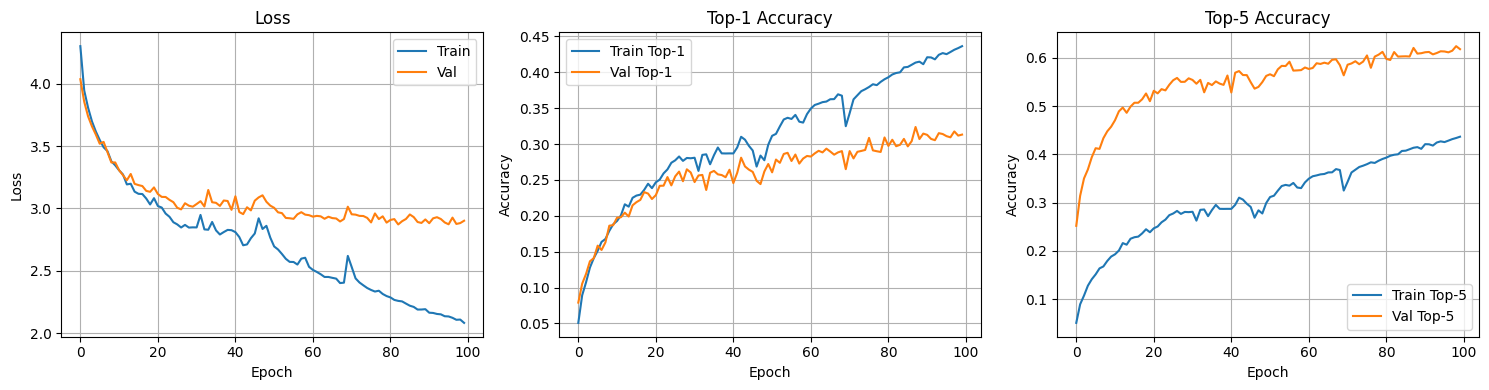

NameError: name 'test_loss' is not defined

In [9]:
device = torch.device(DEFAULT_DEVICE)
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    projection_dim=projection_dim,
    num_patches=num_patches,
    num_heads=num_heads,
    transformer_units=[projection_dim*2, projection_dim],
    transformer_layers=transformer_layers,
    mlp_head_units=mlp_head_units
).to(device)
trainloader, valloader, testloader = get_cifar100_loaders(batch_size, image_size=image_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
train_loss, train_acc1 = [], []
train_acc5 = []
val_loss, val_acc1 = [], []
val_acc5 = []

t0 = time.time()
best_epoch_train_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total, correct_1, correct_5, val_1, val_5 = 0, 0, 0, 0, 0

    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds_1 = logits.topk(1, dim=1)  
        _, preds_5 = logits.topk(5, dim=1)  
        total += labels.size(0)
        correct_1 += (preds_1.squeeze(1) == labels).sum().item()
        correct_5 += (preds_5 == labels.view(-1,1)).any(dim=1).sum().item()
        # 動態顯示當前 loss 和 accuracy
        loop.set_postfix(loss=running_loss/(total/images.shape[0]), top1_acc=correct_1/total, top5_acc=correct_5/total)
        
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = correct_1 / total
    train_loss.append(epoch_train_loss)
    train_acc1.append(epoch_train_acc)
    train_acc5.append(correct_5 / total)

    # 每次訓練完做一次validation
    with torch.no_grad():
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        loop2 = tqdm(valloader, desc="Validation", leave=True)
        for images, labels in loop2:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            val_running_loss += loss.item()
            _, preds_1 = logits.topk(1, dim=1)  
            _, preds_5 = logits.topk(5, dim=1)  
            val_total += labels.size(0)
            val_1 += (preds_1.squeeze(1) == labels).sum().item()
            val_5 += (preds_5 == labels.view(-1,1)).any(dim=1).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = val_1 / val_total
        val_loss.append(epoch_val_loss)
        val_acc1.append(epoch_val_acc)
        val_acc5.append(val_5 / val_total)
    # save model if better
    if epoch_train_acc > best_epoch_train_acc:
        best_epoch_train_acc = epoch_train_acc
        save_model(model, MODEL_PATH, existed="overwrite")

    
# 測試
model.eval()
with torch.no_grad():
    val_running_loss, correct_1, correct_5, val_total = 0.0, 0, 0, 0
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        val_running_loss += loss.item()
        _, preds_1 = logits.topk(1, dim=1)  
        _, preds_5 = logits.topk(5, dim=1)  
        val_total += labels.size(0)
        correct_1 += (preds_1.squeeze(1) == labels).sum().item()
        correct_5 += (preds_5 == labels.view(-1,1)).any(dim=1).sum().item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_acc_1 = correct_1 / val_total
    epoch_val_acc_5 = correct_5 / val_total

# 5. 繪製並儲存訓練曲線
os.makedirs("figure", exist_ok=True)

plot_loss_accuracy(
    train_loss=train_loss, val_loss=val_loss,
    train_top1=train_acc1, val_top1=val_acc1,
    train_top5=train_acc1, val_top5=val_acc5,
    filename="figure/vit_loss_accuracy.png"
);
# 6. 測試並顯示最終結果
#test_loss, test_accuracy, _ = evaluate(model, testloader, criterion)
print(f"Test loss={epoch_val_loss:.4f}, top1 accuracy={epoch_val_acc_1:.4f}, top1 accuracy={epoch_val_acc_1:.4f}")
print(f"Total training time: {time.time() - t0:.1f}s")


In [11]:
print(f"Test loss={epoch_val_loss:.4f}, top1 accuracy={epoch_val_acc_1:.4f}, top5 accuracy={epoch_val_acc_5:.4f}")
print(f"Total training time: {time.time() - t0:.1f}s")

Test loss=2.3790, top1 accuracy=0.3932, top5 accuracy=0.6934
Total training time: 3783.6s


# QConfig

In [12]:
class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    
    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        #########Implement your code here##########
        if scale <= 0:  # Handle non-positive scale values
            return 2 ** -max_shift_amount  # Return a safe default value

        # Calculate the power of 2 closest to the scale
        exponent = math.log2(scale)

        # Clamp the exponent to the allowed range
        exponent = max(-max_shift_amount, min(exponent, max_shift_amount))

        # Return the power of 2
        return (2.0 ** exponent)
        ##########################################

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        #########Implement your code here##########
        max_num = 2**7 - 1
        max_range = max(abs(min_val), abs(max_val))
        scale = max_range / max_num
        
        zero_point = 0 if self.dtype == torch.qint8 else max_num
        
        ##########################################
        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

In [ ]:
'''checkpoint = torch.load(MODEL_PATH, map_location='cpu')  # [2]

# 如果你存的是 state_dict（dict of name→Tensor）
if isinstance(checkpoint, dict):
    print("Keys and tensor shapes in state_dict:")
    total_params = 0
    for name, tensor in checkpoint.items():
        shape = tuple(tensor.shape)
        numel = tensor.numel()
        total_params += numel
        print(f"  {name}: shape={shape}, params={numel}")
    print(f"Total parameters: {total_params}")
else:
    # 如果你存的是整個模型物件
    print("Checkpoint is a model instance:")
    print(checkpoint)
with open('model_parameters.txt', 'w') as f:
    for name, tensor in checkpoint.items():
        f.write(f"{name}: {tuple(tensor.shape)}\n")'''

In [13]:
# reset_seed(0)
DEVICE = "cpu"
torch.backends.quantized.engine = 'fbgemm'
# 1. 先從 DataLoader 拿到一筆範例，讀出通道數與圖像大小
in_channels, in_size = trainloader.dataset[0][0].shape[:2]

# 2. 建立與訓練時完全相同的 ViT 架構，並切到 CPU、eval 模式
model_q = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    projection_dim=projection_dim,
    num_patches=num_patches,
    num_heads=num_heads,
    transformer_units=transformer_units,
    transformer_layers=transformer_layers,
    mlp_head_units=mlp_head_units
).eval().cpu()

# 3. 載入你先前儲存的 state_dict
model_q.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
# --- 2. 包裝模型並指定 QConfig ---
# ViT 是非常規 CNN，無 fuse 需求，直接包 QuantWrapper
model_q = tq.QuantWrapper(model_q)  
model_q.qconfig = CustomQConfig.POWER2.value
# 放回CPU
model_q.cpu()
trainloader_cpu = DataLoader(trainloader.dataset, batch_size=batch_size, shuffle=False)

# --- 3. 準備量化 (插入 observer) ---
tq.prepare(model_q, inplace=True)

# --- 4. 校準 (用 trainloader 跑 forward) ---
model_q.eval()
with torch.no_grad():
    #for i, (images, _) in enumerate(trainloader):
    #    if i >= 10: break            # 取前 10 批做校準
    #    model_q(images.to(DEVICE))
    loop = tqdm(trainloader, desc="Calibrating", leave=True)
    for data, _ in loop:
        data = data.to(device)
        model_q(data.cpu())
# --- 5. 轉換為量化模型 ---
tq.convert(model_q, inplace=True)
'''
for name, module in model_q.named_modules():
    if isinstance(module, nnq.Linear):
        print(f"量化成功層: {name}")
    elif isinstance(module, nn.Linear):
        print(f"未量化層: {name}")
'''
# --- 7. 儲存量化模型 ---
os.makedirs("weights", exist_ok=True)
torch.save(model_q.state_dict(), QUANT_MODEL_PATH)
print("Quantized model saved to " + QUANT_MODEL_PATH)

# --- 6. 評估量化後模型效能 ---
#quant_loss, quant_acc, _ = evaluate(model_q, testloader, criterion, DEVICE)
model.eval()
with torch.no_grad():
    val_running_loss, correct_1, correct_5, val_total = 0.0, 0, 0, 0
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        val_running_loss += loss.item()
        _, preds_1 = logits.topk(1, dim=1)  
        _, preds_5 = logits.topk(5, dim=1)  
        val_total += labels.size(0)
        correct_1 += (preds_1.squeeze(1) == labels).sum().item()
        correct_5 += (preds_5 == labels.view(-1,1)).any(dim=1).sum().item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_acc_1 = correct_1 / val_total
    epoch_val_acc_5 = correct_5 / val_total

print(f"Quantized top1 accurcay: {epoch_val_acc_1:.4f} Quantized top5 accurcay: {epoch_val_acc_5:.4f}")



#original_size = os.path.getsize('./weights/cifar10/vgg.pt') / 1e6
#quantized_size = os.path.getsize(QUANT_MODEL_PATH) / 1e6
#print(f"Original model size: {original_size:.2f} MB")
#print(f"Quantized model size: {quantized_size:.2f} MB")
#print(f"Size reduction: {(1 - quantized_size/original_size) * 100:.2f}%")

/tmp/ipykernel_31/2777167575.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_q.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
Calibrating: 100%|█████

Quantized model saved to ./weights/quant_vit.pt
Quantized top1 accurcay: 0.3948 Quantized top5 accurcay: 0.6938
